In [239]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob

In [240]:
image_directory = '/content/image'
mask_directory = '/content/mask'

In [241]:
SIZE = 256
num_images = 1000

Load images and masks in order so they match

In [242]:
image_names = glob.glob("/content/image/*.jpg")
print(image_names)
image_names.sort()
print(image_names)
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img, 0) for img in image_names_subset]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

['/content/image/0704.jpg', '/content/image/0881.jpg', '/content/image/0316.jpg', '/content/image/0327.jpg', '/content/image/0788.jpg', '/content/image/0159.jpg', '/content/image/0956.jpg', '/content/image/0340.jpg', '/content/image/0177.jpg', '/content/image/0477.jpg', '/content/image/0591.jpg', '/content/image/0249.jpg', '/content/image/0306.jpg', '/content/image/0164.jpg', '/content/image/0935.jpg', '/content/image/0312.jpg', '/content/image/0962.jpg', '/content/image/0329.jpg', '/content/image/0121.jpg', '/content/image/0425.jpg', '/content/image/0861.jpg', '/content/image/0201.jpg', '/content/image/0830.jpg', '/content/image/0655.jpg', '/content/image/0781.jpg', '/content/image/0104.jpg', '/content/image/0850.jpg', '/content/image/0454.jpg', '/content/image/0731.jpg', '/content/image/0271.jpg', '/content/image/0875.jpg', '/content/image/0627.jpg', '/content/image/0640.jpg', '/content/image/0382.jpg', '/content/image/0193.jpg', '/content/image/0395.jpg', '/content/image/0218.jpg', 

In [243]:
mask_names = glob.glob("/content/mask/*.jpg")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset,axis = 3)

In [244]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (1000, 256, 256, 1)
Mask data shape is:  (1000, 256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 2

In [245]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [246]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


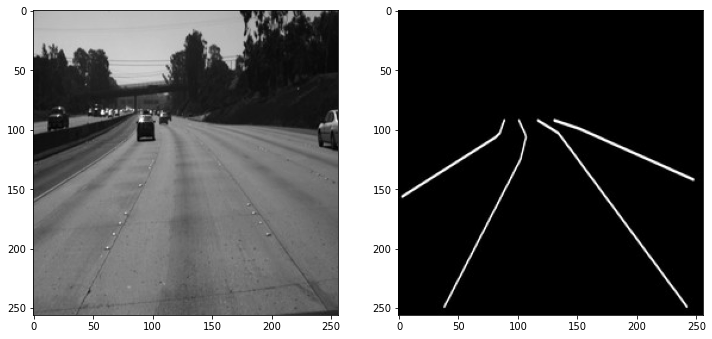

In [247]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [248]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [249]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [250]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 256, 256, 64  640         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_144 (Batch  (None, 256, 256, 64  256        ['conv2d_152[0][0]']             
 Normalization)                 )                                                     

In [251]:
from keras.callbacks import EarlyStopping

In [255]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=30, 
                    validation_data=(X_test, y_test),              
                    shuffle=False)


Epoch 1/50
50/50 [==============================] - 21s 430ms/step - loss: 0.0542 - accuracy: 0.9259 - val_loss: 0.0987 - val_accuracy: 0.9262
Epoch 2/50
50/50 [==============================] - 21s 426ms/step - loss: 0.0509 - accuracy: 0.9259 - val_loss: 0.1001 - val_accuracy: 0.9262
Epoch 3/50
50/50 [==============================] - 21s 426ms/step - loss: 0.0483 - accuracy: 0.9260 - val_loss: 0.0849 - val_accuracy: 0.9262
Epoch 4/50
50/50 [==============================] - 21s 427ms/step - loss: 0.0460 - accuracy: 0.9261 - val_loss: 0.0734 - val_accuracy: 0.9264
Epoch 5/50
50/50 [==============================] - 21s 426ms/step - loss: 0.0443 - accuracy: 0.9261 - val_loss: 0.0772 - val_accuracy: 0.9263
Epoch 6/50
50/50 [==============================] - 21s 426ms/step - loss: 0.0426 - accuracy: 0.9262 - val_loss: 0.0665 - val_accuracy: 0.9264
Epoch 7/50
50/50 [==============================] - 21s 426ms/step - loss: 0.0412 - accuracy: 0.9263 - val_loss: 0.0592 - val_accuracy: 0.9265

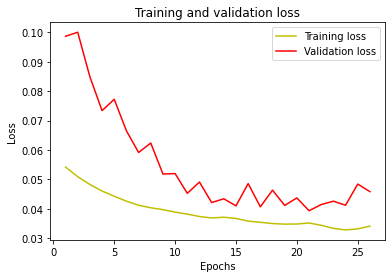

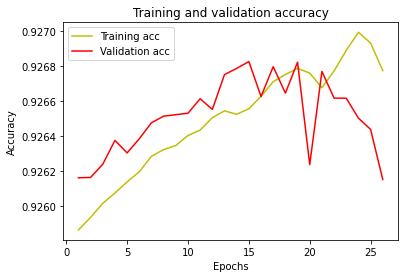

In [256]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model.predict(X_test)


(1, 256, 256, 1)
(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


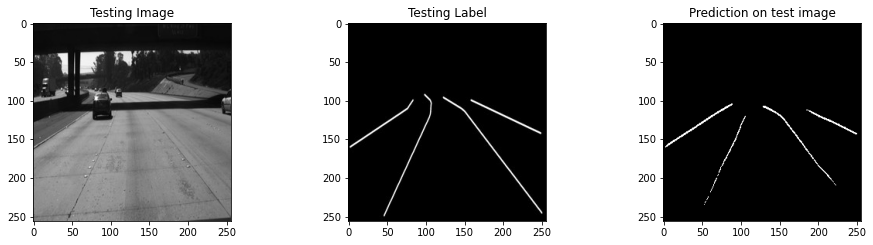

In [257]:

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)
print(prediction)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

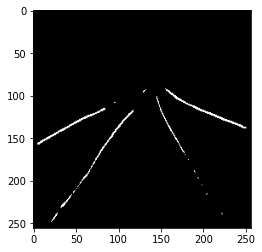

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(720, 1280)


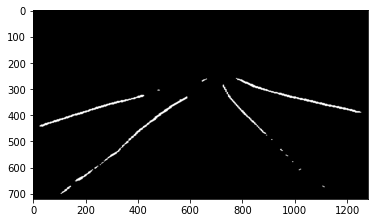

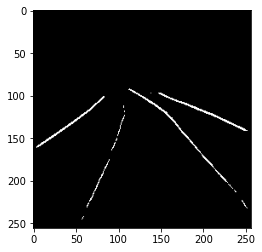

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(720, 1280)


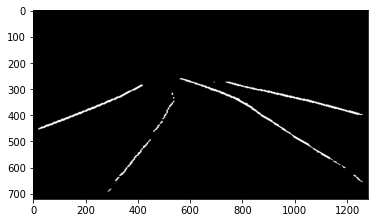

In [258]:
from skimage.transform import resize
for i in range(0,2):
  test_img = X_test[i]
  ground_truth=y_test[i]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
  plt.imshow(prediction, cmap='gray')
  plt.show()
  res = cv2.resize(prediction, dsize=(1280, 720), interpolation=cv2.INTER_CUBIC)
  print(res)
  print(res.shape)
  plt.imshow(res, cmap='gray')
  plt.imsave('filename.png', res, cmap='gray')
  plt.show()
  